<a href="https://colab.research.google.com/github/willfinnigan/kinetics/blob/master/Engineering%20a%20seven%20enzyme%20biotransformation%20using%20mathematical%20modelling%20and%20characterized%20enzyme%20parts/Esterase_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Esterase](https://github.com/willfinnigan/kinetics/raw/master/Engineering%20a%20seven%20enzyme%20biotransformation%20using%20mathematical%20modelling%20and%20characterized%20enzyme%20parts/figures/esterase.jpg)

# Setup Notebook

In [1]:
#@title Install and import packages {display-mode: "form"}
!pip install -q kinetics==1.1.4

import kinetics
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

%matplotlib inline
%config InlineBackend.figure_format ='retina'

data_url = 'https://github.com/willfinnigan/Seven_enzyme_biotransformation_2019/blob/master/experimental_data.xlsx?raw=true'

plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize']  = 8 
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 22

     |████████████████████████████████| 757kB 7.7MB/s 
     |████████████████████████████████| 942kB 42.4MB/s 


In [0]:
#@title Functions for plotting {display-mode: "form"}
substrate_colours = {"Ester" : "#8C0000",
                     "Acid" : "#000090",
                     "Aldehyde" : "#068400",
                     "Alcohol" : "#CA6602"}

substrate_symbols = {"Ester" : "o",
                     "Acid" : "s",
                     "Aldehyde" : "^",
                     "Alcohol" : "v"}


def setup_graph(y_max=4000, x_max=240):
    plt.xlabel('Time (mins)')
    plt.ylabel("μM substrate")
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.minorticks_on()
    plt.xticks(np.arange(0, x_max+1, 30))
    plt.yticks(np.arange(0, y_max+1, 500))
    
    
def add_ua_model_to_graph(substrates_to_add, dataframes,
                          substrate_colours=substrate_colours):
    
    for substrate in substrates_to_add:
        df = dataframes[substrate]
    
        time = df['Time'].tolist()
        high = df['High'].tolist()
        low = df['Low'].tolist()
        mean = df['Mean'].tolist()
        
        hight_line = plt.plot(time, high, color=substrate_colours[substrate], linestyle="--", linewidth = 0.5)
        low_line = plt.plot(time, low,  color=substrate_colours[substrate], linestyle="--", linewidth = 0.5)
        mean_line = plt.plot(time, mean,  color=substrate_colours[substrate], linewidth = 1.5, label=substrate)
        
    plt.legend(ncol=4)
    
        
def add_experimental_data_to_graph(substrates_to_add, exp_data_df,
                                   substrate_colours=substrate_colours,
                                   substrate_symbols=substrate_symbols):
    time_data = exp_data_df["Time"]
    for substrate in substrates_to_add:
        for column in exp_data_df:
            if substrate in column:
                data_to_plot = exp_data_df[column]
                plt.scatter(time_data, data_to_plot,
                            edgecolors="black",
                            c=substrate_colours[substrate],
                            marker=substrate_symbols[substrate])
                

# Esterase one substrate

In [0]:
#@title Esterase one substrate reaction {display-mode: "form"}
est_one_substrate = kinetics.One_irr(kcat="est_kcat", kma="est_km_ester",
                                     a='Ester', enz='est',
                                     substrates=['Ester'], products=['Acid'])

est_one_substrate.parameter_bounds = {"est_km_ester": (1125, 1875),
                                      "est_kcat": (4.5, 7.5)}

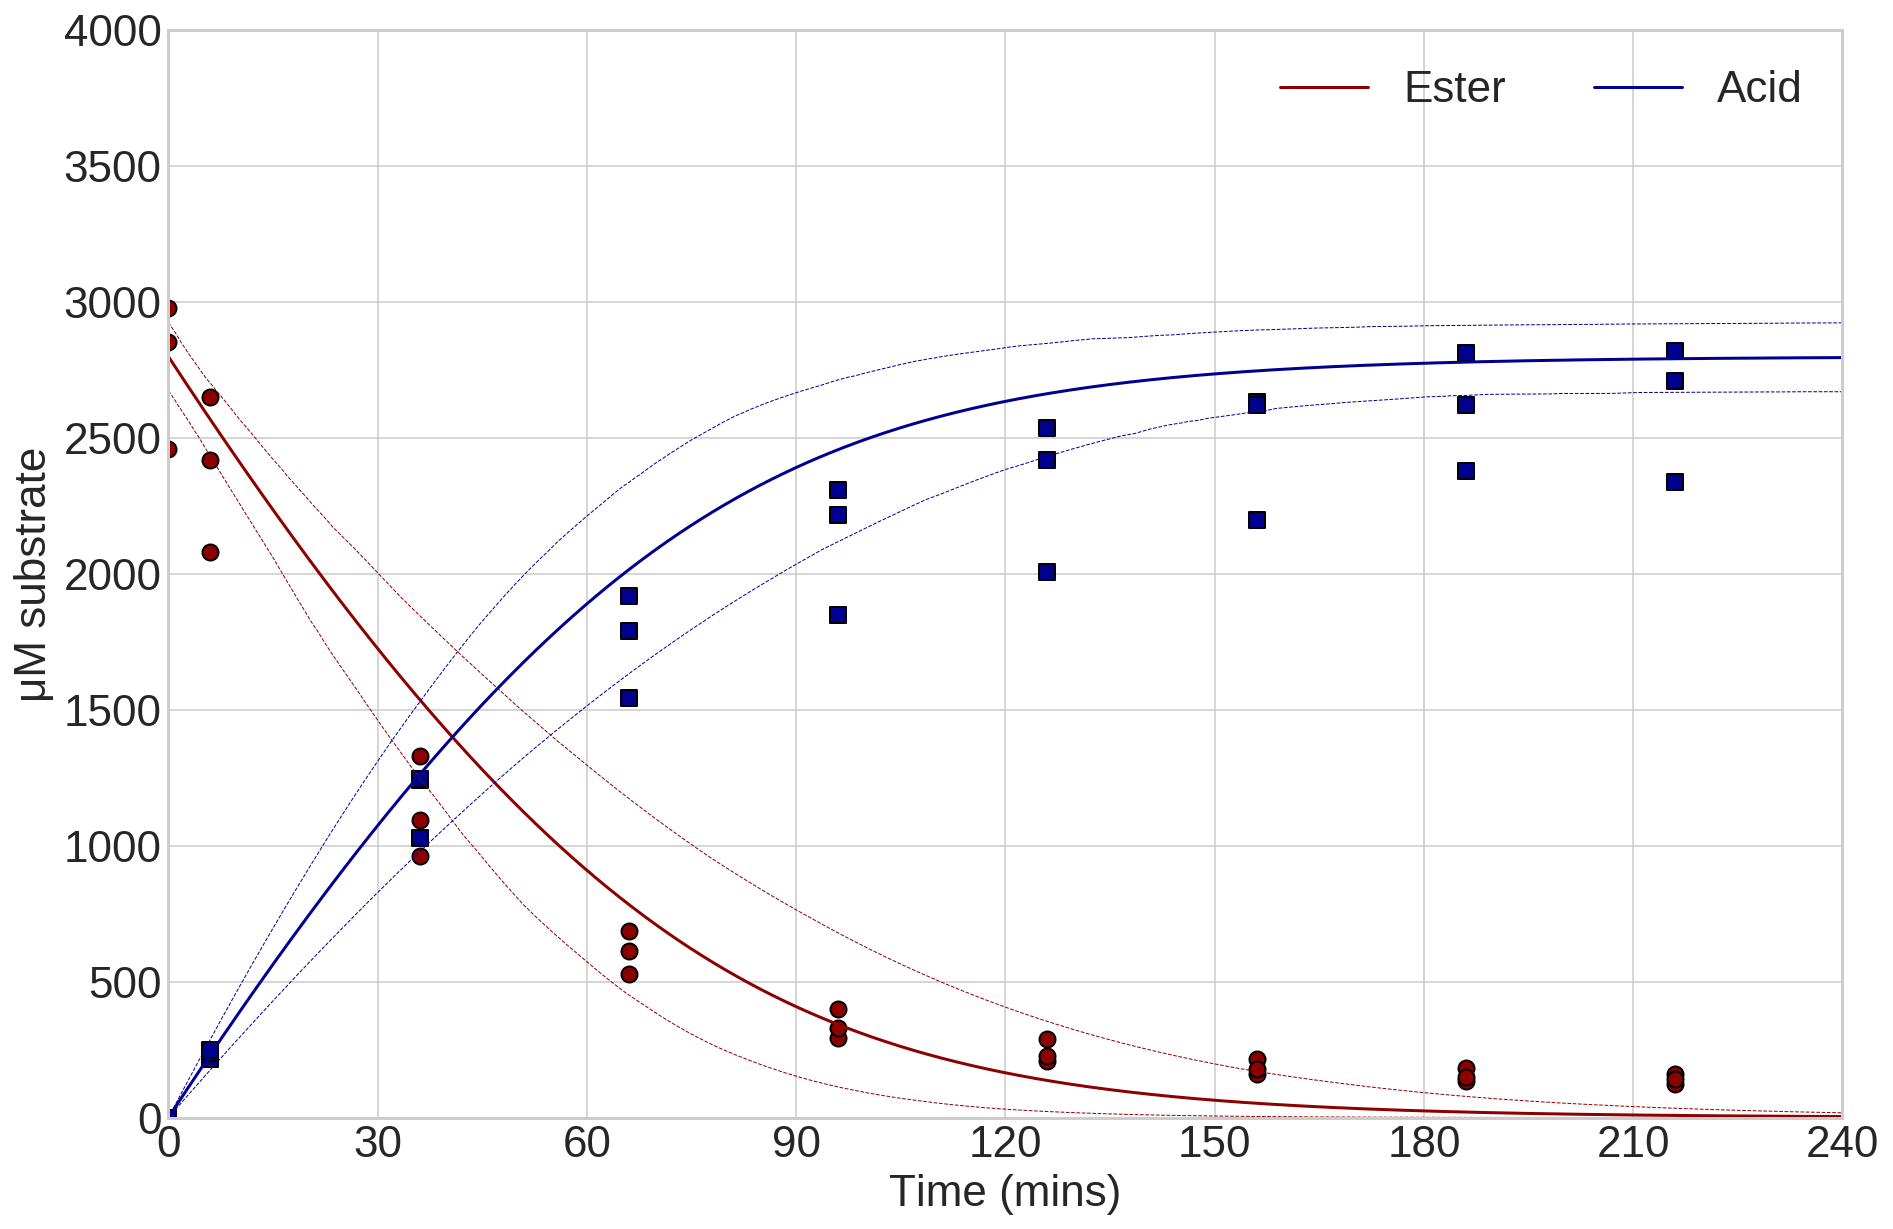

In [4]:
# Define the model
model = kinetics.Model(logging=False)
model.append(est_one_substrate)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"est" : (10, 0.05),
                               "Ester" : (2800, 0.05)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

# Plot the model vs experimental daya
substrates = ["Ester", "Acid"]
setup_graph(y_max=4000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'esterase_only')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

# Esterase reversible with water

In [0]:
#@title Esterase with water - two substrate reversible reaction {display-mode: "form"}
est_fwd_pingpong = kinetics.Two_ping_pong_irr(kcat="est_kcat_fwd", kma="est_km_ester", kmb='est_km_water',
                                              a='Ester', b='H2O', enz='est',
                                              substrates=['Ester', "H2O"],
                                              products=['Acid', 'MeOH'])

est_rev_pingpong = kinetics.Two_ping_pong_irr(kcat="est_kcat_rev", kma="est_km_acid", kmb='est_km_meoh',
                                              a='Acid', b='MeOH', enz='est',
                                              substrates=['Acid', 'MeOH'],
                                              products=['Ester', "H2O"])

est_fwd_pingpong.parameter_bounds = {"est_kcat_fwd": (4.5, 7.5),
                                     "est_km_ester": (1125, 1875),
                                     "est_km_water" : (1000, 100000)}

est_rev_pingpong.parameter_bounds = {"est_kcat_rev": (1, 50),
                                     "est_km_meoh": (1000, 100000),
                                     "est_km_acid" : (100, 100000)}

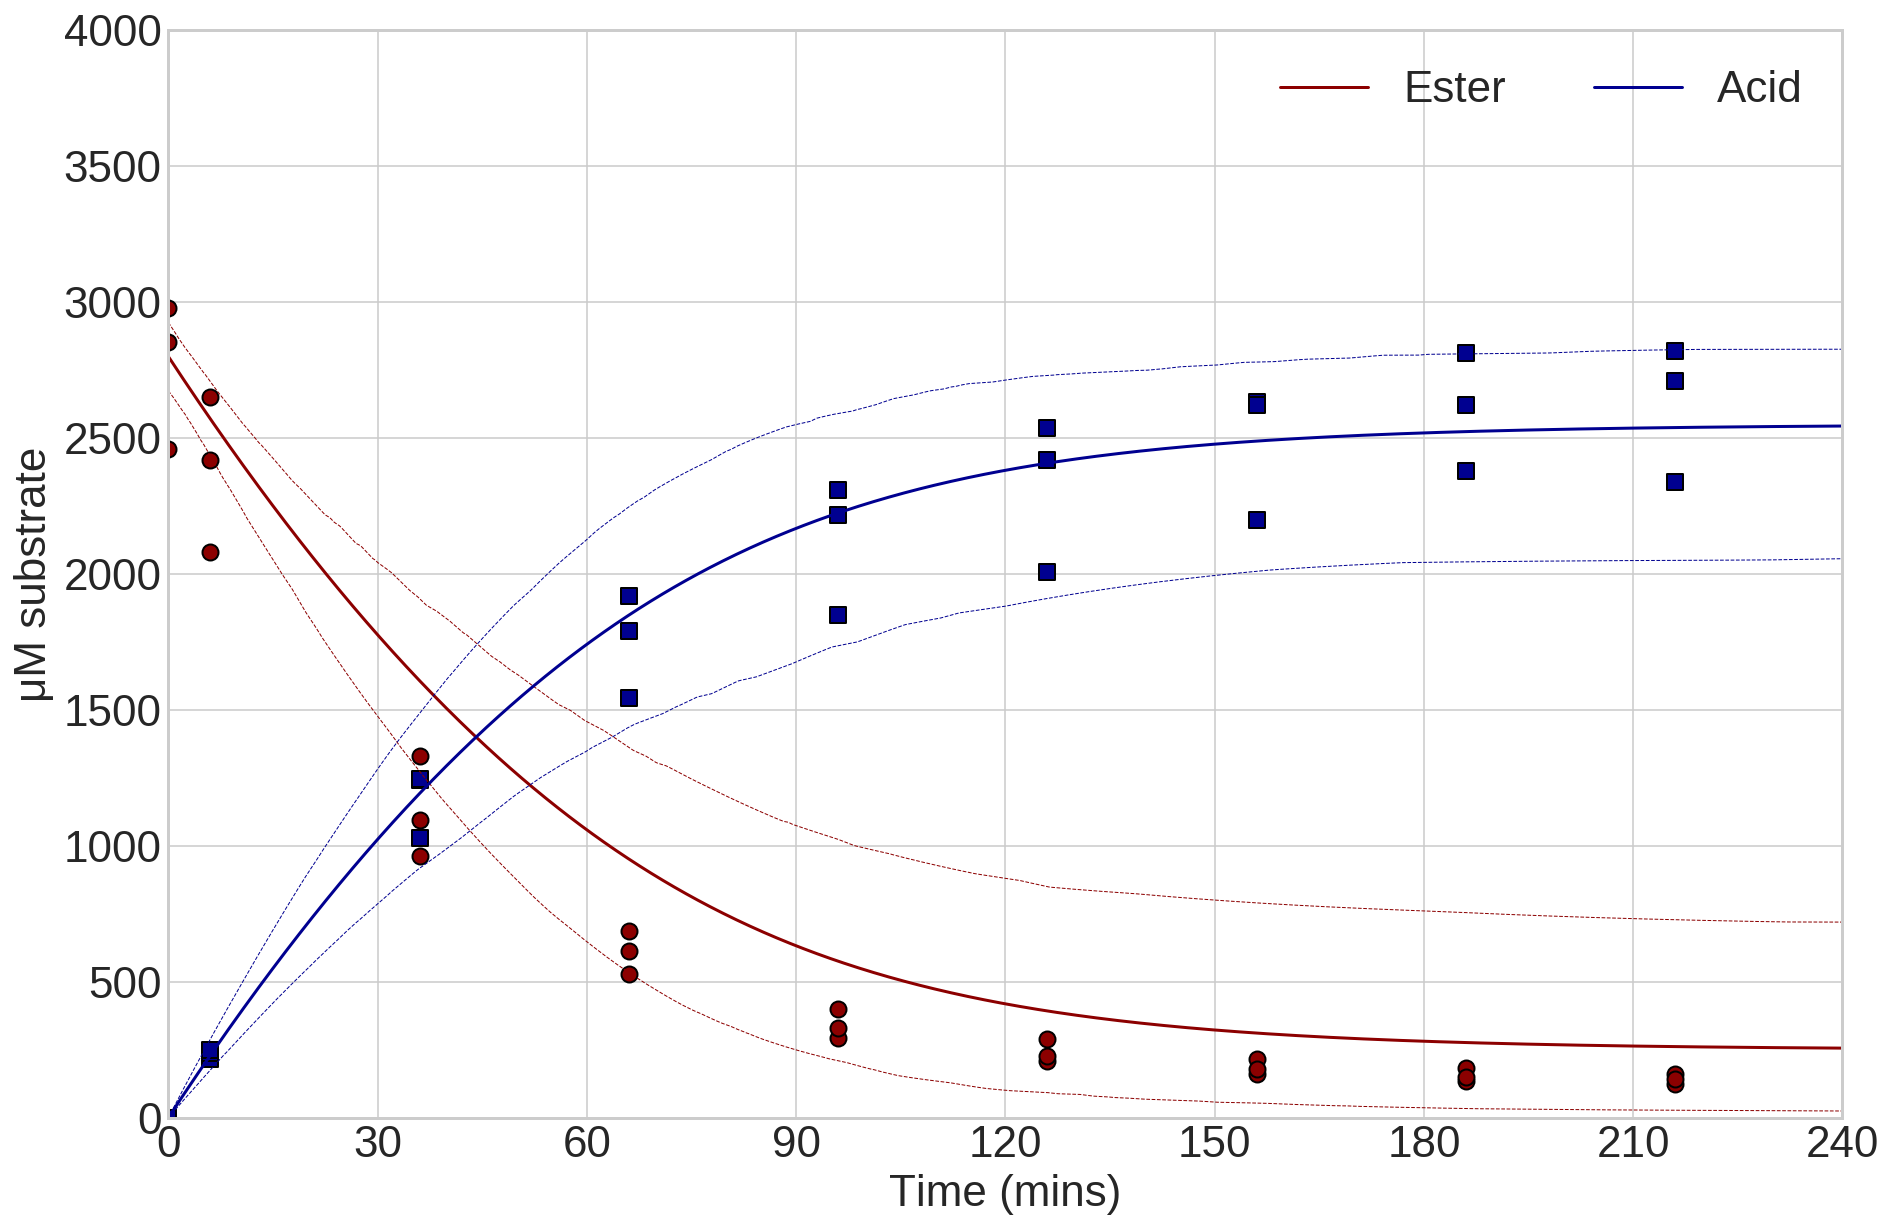

In [6]:
# Define the model
model = kinetics.Model(logging=False)
model.append(est_fwd_pingpong)
model.append(est_rev_pingpong)

# Set the initial species concentrations in the model (in uM)
model.reaction_species.update({"est" : (10, 0.05),
                               "Ester" : (2800, 0.05),
                               "H2O" : (55000000, 0)})

# Set the model time: model.set_time(start, end, steps)
model.set_time(0, 240, 1000)
model.setup_model();

# Run the model as an uncertainty analysis
ua = kinetics.UA(model, num_samples=500, quartile_range=95, logging=True)
ua.run_standard_ua()

# Plot the model vs experimental daya
substrates = ["Ester", "Acid"]
setup_graph(y_max=4000, x_max=240)
lines = add_ua_model_to_graph(substrates, ua.substrate_dataframes)
exp_data = pd.read_excel(data_url, 'esterase_only')
add_experimental_data_to_graph(substrates, exp_data)
plt.show()

## Sensitivity analysis for the two substrate, reversible esterase reaction

In [7]:
substrate = 'Acid'

sa = kinetics.SA(model,
                 number_samples=500,
                 second_order=False,
                 conf_level=0.95,
                 num_resample=100);

sa.make_saltelli_samples();
sa.run_models();
sa.analyse_sobal_sensitivity_substrate_concentration_at_t(240, substrate)

df = sa.dataframe_output  

df = df.sort_values("ST", ascending=False)

df = df[df["ST"] > 0.02]

display(df)

self.problem, self.samples and self.parsed_samples set by make_saltelli_samples
running all models


100%|██████████| 5000/5000 [00:20<00:00, 246.90it/s]

samples run, model outputs saved in self.output
self.output_for_analysis updated with outputs for substrate Acid at timepoint 240
self.analysis updated with sobal sensitivity analysis output
Sobal sensitivity analysis saved as dataframe in self.dataframe_output


,S1,S1_conf,ST,ST_conf
est_km_acid,0.125116,0.080974,0.443676,0.142127
est_kcat_rev,0.248835,0.077965,0.439027,0.178770
est_km_meoh,0.198745,0.082221,0.339168,0.126903
Ester,0.085369,0.032955,0.086579,0.019172
est_kcat_fwd,0.026265,0.026104,0.040939,0.009474
est_km_ester,0.019723,0.015602,0.021856,0.005047
